In [73]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, converge_ZNE_loocv

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection

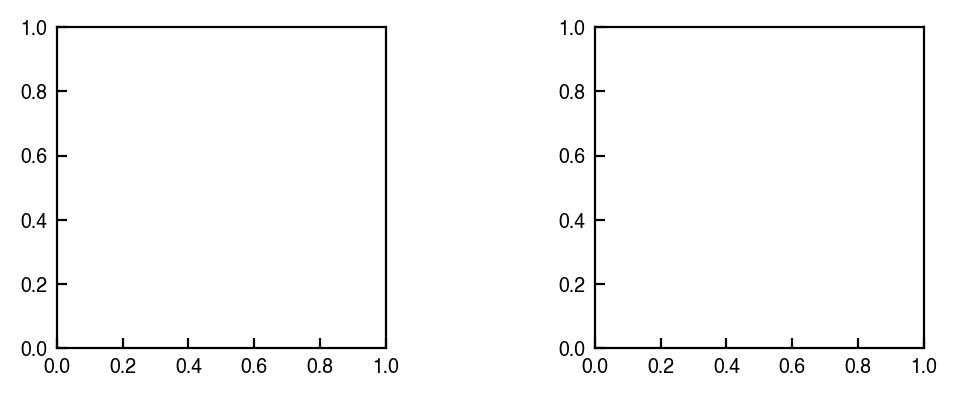

In [74]:
import matplotlib as mpl

columns = 2
rows = 1
scol=(3+3/8) #single column width of PRL,
dcol=2*scol # double column,
size_col = scol*columns#[scol, dcol][columns-1]
size_row = scol*rows#scol, dcol][rows-1]

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": False,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(1,6)  # 2x2 grid
ax_a = fig.add_subplot(gs[:2])
ax_b = fig.add_subplot(gs[3:5])
#ax_ci = fig.add_subplot(gs[2])
#ax_ci = fig.add_subplot(gs[3])



In [75]:
""" Oscillations without frequency corrections. Imports data from experiments, then performs processing and plotting. """
#Data sets from "Round 2 Verification" and "Round 2 Initial"
#np.savez('data_dump', times = t_w_data['x']*us, thetas = thetas, qubits = qubit_index, Omegas = Omegas, data=t_w_data['probs'])

#cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
cmap = cm.get_cmap('Reds')
#Crop the lowest points from cmap, start at 0.5:




## START NOT AT 0:



initial_file = np.load("../data/ROUND_2_INITIAL/data_dump.npz")

plotting_version = 1

times = initial_file['times']
thetas = initial_file['thetas']
qubits = initial_file['qubits']
Omegas = initial_file['Omegas']
#print(Omegas[0])
data = initial_file['data']
std_matrix = initial_file['std_matrix']
#print(data.shape)
#print(data.shape)
qubit_to_use = 2
qubit_index_full = qubits[qubit_to_use]
data_qubit = data[:,qubit_index_full,:]
stds_qubit = std_matrix[:,qubit_index_full,:]
#print(data_qubit.shape)
theta_qubit = thetas[:,qubit_to_use]
#print(theta_qubit)
Omega_qubit = Omegas[:,qubit_to_use]
#print(thetas)

sorting_index = np.argsort(theta_qubit)
theta_qubit = theta_qubit[sorting_index]
data_qubit = data_qubit[sorting_index]
stds_qubit = stds_qubit[sorting_index]
Omega_qubit = Omega_qubit[sorting_index]

#ax_a.legend()
#######################
#Redoing the color bar:
def create_linear_function(y_at_0_5):
    # Given points
    x1, y1 = 0.5, y_at_0_5
    x2, y2 = 1, 1
    
    # Calculate slope (a) and intercept (b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    
    # Return the linear function
    def linear_function(x):
        return a * x + b
    
    return linear_function

linear_func = create_linear_function(0.5)

print(theta_qubit)

new_labels = ['0.04', '0.08', '0.12', '0.16', '0.20']
new_tick_locations = linear_func(np.array([0.04, 0.08, 0.12, 0.16, 0.20])/max(theta_qubit))

normalized_ZNE_points_for_color = linear_func(theta_qubit/max(theta_qubit))
#cm_subsection = np.linspace(0.2, 1.0, len(ZNE_points) )
Reds = [ cm.Reds(x) for x in normalized_ZNE_points_for_color ]
cmap = LinearSegmentedColormap.from_list('name', Reds)
print(Reds)
#get a blue to red colormap
colors = Reds#cmap(np.linspace(0, 1, len(ZNE_points)))
#make a test plot that just plots all the reds



#print(colors)
# Add a color bar:
colorbar = plt.cm.ScalarMappable(cmap=cmap)
#colorbar.set_array(ZNE_points[1:] * baseline)

# Add color bar to ax_bii
labels = np.array(['{:.3f}'.format(theta_qubit[i]) for i in range(len(theta_qubit))])

cbar = plt.colorbar(colorbar, ax=ax_a, ticks=new_tick_locations)
cbar.set_label(r'Error Strength ($\bar{n}$)',usetex=1)

#cbar.set_label(r'Standard Deviation, $\sigma$', labelpad=5)
#labels[0] = ''
cbar.set_ticklabels(new_labels)

#####################


for index in range(len(theta_qubit)):
    ax_a.plot(times, data_qubit[index], color=colors[index], label=theta_qubit[index], linewidth=1)#, yerr=stds_qubit[index])#, alpha=max(0.2,(1/(index+1))))
    ax_a.fill_between(times, data_qubit[index] - stds_qubit[index], data_qubit[index] + stds_qubit[index], color=colors[index], alpha=0.15)
ax_a.plot(times, (0.5 - np.cos(Omega_qubit[0]*times)/2), color='black', zorder=100, ls='--', lw=0.8)

[0.057793   0.06574115 0.07655879 0.10509314 0.11692185 0.15612184
 0.15612184 0.18123138 0.2261819 ]
[(0.9882352941176471, 0.7270280661284121, 0.6241445597846982, 1.0), (0.9882352941176471, 0.6816301422529797, 0.5721030372933488, 1.0), (0.9882352941176471, 0.6210995770857363, 0.5027143406382161, 1.0), (0.9854825067281815, 0.46243752402921956, 0.3369473279507882, 1.0), (0.9776701268742791, 0.38966551326412935, 0.27358708189158026, 1.0), (0.8636216839677047, 0.15978469819300267, 0.14186851211072665, 1.0), (0.8636216839677047, 0.15978469819300267, 0.14186851211072665, 1.0), (0.7317954632833525, 0.07889273356401384, 0.10019223375624758, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_8432/1235227185.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


<Figure size 1350x417.173 with 0 Axes>

In [76]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
x, y = 1, 0
ax_ci = inset_axes(ax_b, width="30%", height="70%", bbox_to_anchor=(x, y, 1, 1), bbox_transform=ax_b.transAxes, loc='lower left')

# Define the x-range and y-range to zoom in on
x_inset_range = (9e-6, 10e-6)
y_inset_range = (0.6, 1)

# Plot data in the inset axes
# ax_ci.plot(x, y, label='Inset Data')  # Uncomment and replace with actual data
ax_ci.set_xlim(x_inset_range)
ax_ci.set_ylim(y_inset_range)

# Optional: Add a box showing the zoomed area
inset_zoom = ax_b.indicate_inset_zoom(ax_ci, edgecolor="k", )
connector_lines = inset_zoom[1]  # The connector lines are returned as a tuple
connector_lines[0].set_visible(True)  # Hide the lower-left connector line
connector_lines[1].set_visible(False)   # Show the upper-left connector line
connector_lines[2].set_visible(False)   # Show the lower-right connector line
connector_lines[3].set_visible(True)  # Hide the upper-right connector line

# Turn off the Y axis in the inset
#ax_ci.yaxis.set_visible(False)
#ax_ci.set_yticklabels([])
ax_ci.set_xticks([ 0.1, 0.2])
ax_ci.set_xticklabels([ '0.1', '0.2'])
ax_ci.set_yticks([0.8])
ax_ci.set_yticklabels(['0.8'])
ax_ci.set_xlabel(r'Error Strength ($\bar{n}$)',usetex=1)


# Move the labels inside the plot
ax_ci.tick_params(axis='x', direction='in', labeltop=False, labelbottom=True)
ax_ci.tick_params(axis='y', direction='in', labelleft=True, labelright=False)#, pad=-50)

#ax_ci.set_xticklabels(ax_ci.get_xticks(), )

In [77]:
""" Oscillations without frequency corrections. Imports data from experiments, then performs processing and plotting. """
#Data sets from "Round 2 Verification" and "Round 2 Initial"
#np.savez('data_dump', times = t_w_data['x']*us, thetas = thetas, qubits = qubit_index, Omegas = Omegas, data=t_w_data['probs'])

#cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])

initial_file = np.load("../data/ROUND_2_VERIFICATION/data_dump.npz")

plotting_version = 1

times = initial_file['times']
thetas = initial_file['thetas']
qubits = initial_file['qubits']
Omegas = initial_file['Omegas']
data = initial_file['data']
std_matrix = initial_file['std_matrix']
#print(data.shape)
#print(data.shape)
qubit_to_use = 2
qubit_index_full = qubits[qubit_to_use]
data_qubit = data[:,qubit_index_full,:]
stds_qubit = std_matrix[:,qubit_index_full,:]
#print(data_qubit.shape)
theta_qubit = thetas[:,qubit_to_use]
#print(theta_qubit)
Omega_qubit = Omegas[:,qubit_to_use]
#print(thetas)

#Sort based on ascending theta_qubit. Sort all of the above





for index in range(len(thetas)):
    ax_b.plot(times, data_qubit[index], color=colors[index], label=theta_qubit[index], linewidth=1)#, yerr=stds_qubit[index])#, alpha=max(0.2,(1/(index+1))))
    ax_b.fill_between(times, data_qubit[index] - stds_qubit[index], data_qubit[index] + stds_qubit[index], color=colors[index], alpha=0.15)
ideal_data = 0.5 - np.cos(Omega_qubit[0]*times)/2
ax_b.plot(times, (0.5 - np.cos(Omega_qubit[0]*times)/2), color='black', zorder=100, ls='--', lw=0.8)
#ax_a.legend()

#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(thetas[qubit_to_use])))
#sm.set_array([])
#Add a label to the color bar:

#Performing ZNE:


#ZNE_function = order_poly_instance(5, debug=True)
ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, weights=weights)



ZNE_data = np.zeros(len(times))
ZNE_functions = []
print(data_qubit.shape)
for index in range(len(times)):
    #print(data_qubit[:,index])
    fitted_function = ZNE_function(theta_qubit,data_qubit[:,index], weights=stds_qubit[:,index])
    print(fitted_function)
    ZNE_data[index] = fitted_function(0)
    ZNE_functions.append(fitted_function)

    


ax_b.plot(times, ZNE_data, color='blue')
#Draw the vertical slice: 


index_of_slice = 15


#print(data_qubit[:,index_of_slice])
ax_b.axvline(x=times[index_of_slice], color='black', ls=':')
#print(ZNE_data.shape)
for theta_index in range(len(theta_qubit)):
    ax_ci.errorbar(theta_qubit[theta_index], data_qubit[theta_index, index_of_slice], color=cmap(theta_index/len(thetas)), yerr=stds_qubit[theta_index, index_of_slice], linewidth=1)
    ax_ci.scatter(theta_qubit[theta_index], data_qubit[theta_index, index_of_slice], color=cmap(theta_index/len(thetas)), s=10)
    
dense_theta = np.linspace(0, max(theta_qubit), 1000)
ax_ci.plot(dense_theta, ZNE_functions[index_of_slice](dense_theta), color='purple', label='ZNE Fit')
ax_ci.set_xlim(0, max(theta_qubit)+0.01)


ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, weights=weights)
ZNE_function(theta_qubit,data_qubit[:,index_of_slice], weights=stds_qubit[:,index_of_slice])

"""Generate Simulation Data using Cetina Function and SPAM?"""
theta_axis_data = np.zeros((len(dense_theta), len(times)))
Omega_ideal = Omegas[0, qubit_to_use]
#print(Omega_qubit)
Omega_scaled = np.abs(calibrate_sim_Omegas(dense_theta, Omega_ideal, times))*Omega_ideal
#ax_b.plot(times, cetina_thermal_exp(times, 0, Omega_scaled[0]))
#NEED TO CORRECT THIS FREQUENCY
for theta_index in range(len(dense_theta)):
    theta = dense_theta[theta_index]
    theta_axis_data[theta_index] = cetina_thermal_exp(times, theta, Omega_scaled[theta_index])

ax_ci.plot(dense_theta, theta_axis_data[:,index_of_slice], color='black', linestyle='--', label='Numerical')
ax_ci.scatter(0, ideal_data[index_of_slice], color='black', s=10)

#Error plot: Take the largest error up  to the time and plot on a log plot
baseline_error = np.abs(data_qubit[0] - ideal_data)
ZNE_error = np.abs(ZNE_data - ideal_data)

rolling_max_basline_error = np.maximum.accumulate(baseline_error)
rolling_max_ZNE_error = np.maximum.accumulate(ZNE_error)

#ax_cii.plot(times, rolling_max_basline_error, label=r'$\theta$ = {:.2f}'.format(theta_qubit[0]), color='black')
#ax_cii.plot(times, rolling_max_ZNE_error, label='ZNE', color='blue')
#ax_cii.set_ylabel('Absolute error')
#ax_cii.set_yscale('log')
#ax_cii.hlines(stds_qubit[0,index_of_slice], times[0], times[-1], color='red', ls='--', label='Shot Noise')
#ax_cii.legend()


#cbar_b = fig.colorbar(sm, ax=ax_b)
#cbar_b.set_label(r'$\theta$')

# s
##NEED STANDARD DEVIATION
#THE INDEXES ARE NOT IN ORDER???

/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:931: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(9, 26)
Loocv failed
0.0016666666666666668 + 0.0·x¹ + 0.0·x² + 0.0·x³
Loocv failed
0.11031987502169129 + 0.0·x¹ - 3.7975236429434114·x² +
15.251022103635613·x³
Loocv failed
0.3624908929139515 + 0.0·x¹ - 5.436209927048448·x² + 18.714898423709574·x³
Loocv failed
0.6489232259651019 + 0.0·x¹ - 2.7799688091065295·x² + 5.790951148642857·x³
Loocv failed
0.9258610950686762 + 0.0·x¹ - 10.458354849017997·x² +
37.297306761194385·x³
Loocv failed
0.9966145516466168 + 0.0·x¹ - 2.850127334178073·x² + 1.3997228337236822·x³
Loocv failed
0.8660959806269303 + 0.0·x¹ + 5.852894255328367·x² - 27.780701049392167·x³
Loocv failed
0.6433406117380479 + 0.0·x¹ + 6.557132690702376·x² - 22.725119205727147·x³
Loocv failed
0.2959664725816116 + 0.0·x¹ + 16.49955651404896·x² - 54.18105561338455·x³
Loocv failed
0.0722265381686107 + 0.0·x¹ + 14.39115120691647·x² - 42.73674532187512·x³
Loocv failed
0.006449994705910382 + 0.0·x¹ + 9.645328608955012·x² -
20.31583328790005·x³
Loocv failed
0.13140851499637188 + 0.0·x¹ - 0.11

In [78]:
ax_a.set_ylabel('Population Transfer')
ax_a.set_xlabel(r'Time ($\mu\mathrm{s}$)',usetex=1)
ax_a.set_xticks(np.array([0, .5, 1, 1.5])*1E-5)

ax_a.set_xticklabels([0, 5, 10, 15])
ax_b.set_xlim(0, 1.5E-5)
ax_a.set_xlim(0, 1.5E-5)

#cbar_b.set_label(r"$\theta$", labelpad=-21, y=1.08, rotation=0)
#cbar_a.set_label(r"$\theta$", labelpad=-21, y=1.08, rotation=0)

#ax_a.set_xticklabels([{:.2f}.format(x) for index in range(len(times, 5))])

#ax_ci.set_xlabel(r'Temperature, $\theta$')
#ax_ci.set_ylabel('Population Transfer')
#ax_ci.legend()
#ax_b.set_ylabel('Population Transfer')
ax_b.set_xlabel(r'Time ($\mu\mathrm{s}$)',usetex=1)
ax_b.set_ylabel('Population Transfer')
#ax_b.set_yticklabels([])
ax_b.set_xticks(np.array([0, .5, 1])*1E-5)
ax_b.set_xticklabels([0, 5, 10])


fig.tight_layout()
fig.savefig("Figure_3_v2.pdf", bbox_inches='tight')
fig.savefig("Figure_3_v2.png", bbox_inches='tight', dpi=600)
fig.savefig("Figure_3_v2.svg", bbox_inches='tight', dpi=600)

/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_8432/4008821392.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
